In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("../data/cleaned_telco_churn.csv")


In [5]:
df['Churn'].unique()

array([0, 1])

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

X = df.drop(["Churn"], axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", X_train_scaled.shape, y_train.shape)
print("After SMOTE:", X_train_resampled.shape, y_train_resampled.shape)


Before SMOTE: (5625, 45) (5625,)
After SMOTE: (8260, 45) (8260,)


In [25]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

y_pred_lr = logreg.predict(X_test_scaled)
y_prob_lr = logreg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Results:\n")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))


Logistic Regression Results:

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407

ROC-AUC: 0.83556667408669


In [27]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Results:\n")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


Random Forest Results:

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407

ROC-AUC: 0.8144739634831315


In [33]:
from sklearn.metrics import (
    classification_report,
    f1_score,
    balanced_accuracy_score,
    roc_auc_score,
    average_precision_score
)

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

print("XGBoost Results:\n")
print(classification_report(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_xgb))
print("PR AUC:", average_precision_score(y_test, y_prob_xgb))


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:33:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1033
           1       0.57      0.52      0.54       374

    accuracy                           0.77      1407
   macro avg       0.70      0.69      0.69      1407
weighted avg       0.76      0.77      0.76      1407

F1 Score: 0.5421348314606742
Balanced Accuracy: 0.6878374600742347
ROC AUC: 0.8139511106739623
PR AUC: 0.6186837469090726


In [35]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score
import xgboost as xgb
import numpy as np

def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
    }
    
    model = xgb.XGBClassifier(**param)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    recall = cross_val_score(
        model, X_train, y_train, cv=cv,
        scoring=make_scorer(recall_score),
        n_jobs=-1
    )
    return np.mean(recall)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  

print("Best trial:")
trial = study.best_trial

print(f"  Recall: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42
})

xgb_clf = xgb.XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

print("\nXGBoost Results with Tuned Params:\n")
print(classification_report(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_xgb))
print("PR AUC:", average_precision_score(y_test, y_prob_xgb))


[I 2025-05-17 12:34:10,867] A new study created in memory with name: no-name-5c4d3175-2e8b-4dd7-9554-a42567dd886b
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:34:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:34:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:34:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:34:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: 

Best trial:
  Recall: 0.5484949832775918
  Params: 
    max_depth: 8
    learning_rate: 0.021971551109741333
    n_estimators: 340
    subsample: 0.5123022440828304
    colsample_bytree: 0.9877124364395108
    min_child_weight: 10
    gamma: 2.7862403917550664
    reg_alpha: 1.790159740905587
    reg_lambda: 1.445888253189916

XGBoost Results with Tuned Params:

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1033
           1       0.64      0.54      0.59       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.73      1407
weighted avg       0.79      0.80      0.79      1407

F1 Score: 0.5855072463768116
Balanced Accuracy: 0.7148743859067872
ROC AUC: 0.8415937174834732
PR AUC: 0.6552071842268139


In [39]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score
import xgboost as xgb
import numpy as np
from sklearn.metrics import f1_score

def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
    }
    
    model = xgb.XGBClassifier(**param)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1 = cross_val_score(
        model, X_train, y_train, cv=cv,
        scoring=make_scorer(f1_score),
        n_jobs=-1
    )
    return np.mean(f1)  

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  
print("Best trial:")
trial = study.best_trial

print(f"  Recall: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42
})

xgb_clf = xgb.XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

print("\nXGBoost Results with Tuned Params:\n")
print(classification_report(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_xgb))
print("PR AUC:", average_precision_score(y_test, y_prob_xgb))


[I 2025-05-17 12:42:56,230] A new study created in memory with name: no-name-69ba0768-d591-489d-83a0-57d3e933b4c3
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: 

Best trial:
  Recall: 0.6029124927130856
  Params: 
    max_depth: 9
    learning_rate: 0.06220172823893021
    n_estimators: 339
    subsample: 0.5587115967671624
    colsample_bytree: 0.7239159402280508
    min_child_weight: 8
    gamma: 2.824208282783283
    reg_alpha: 4.098919842057949
    reg_lambda: 1.0365671934810525

XGBoost Results with Tuned Params:

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.55      0.60       374

    accuracy                           0.80      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.79      0.80      0.80      1407

F1 Score: 0.5953757225433526
Balanced Accuracy: 0.7211900337007108
ROC AUC: 0.8419599732879158
PR AUC: 0.6533333323168132


In [49]:
import optuna
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
import numpy as np

def objective(trial):
    estimator = DecisionTreeClassifier(
        max_depth=trial.suggest_int('max_depth', 2, 10),
        random_state=42
    )
    
    model = EasyEnsembleClassifier(
        n_estimators=trial.suggest_int('n_estimators', 5, 20),
        estimator=estimator,
        random_state=42,
        n_jobs=-1
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, X_train, y_train,
        cv=cv,
        scoring=make_scorer(f1_score),
        n_jobs=-1,
        error_score='raise'  # To see errors clearly if they happen
    )
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  F1 Score: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train final model with best params
best_base_estimator = DecisionTreeClassifier(
    max_depth=trial.params['max_depth'],
    random_state=42
)
final_model = EasyEnsembleClassifier(
    n_estimators=trial.params['n_estimators'],
    estimator=best_base_estimator,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train, y_train)


[I 2025-05-17 13:17:42,888] A new study created in memory with name: no-name-111eed8f-84ed-493e-93c2-d68ef696b61d
[I 2025-05-17 13:17:50,121] Trial 0 finished with value: 0.6336528383741691 and parameters: {'max_depth': 5, 'n_estimators': 19}. Best is trial 0 with value: 0.6336528383741691.
[I 2025-05-17 13:17:50,612] Trial 1 finished with value: 0.6041332161688582 and parameters: {'max_depth': 8, 'n_estimators': 6}. Best is trial 0 with value: 0.6336528383741691.
[I 2025-05-17 13:17:51,438] Trial 2 finished with value: 0.6034929629501782 and parameters: {'max_depth': 9, 'n_estimators': 9}. Best is trial 0 with value: 0.6336528383741691.
[I 2025-05-17 13:17:52,087] Trial 3 finished with value: 0.6168872614671703 and parameters: {'max_depth': 8, 'n_estimators': 10}. Best is trial 0 with value: 0.6336528383741691.
[I 2025-05-17 13:17:52,988] Trial 4 finished with value: 0.6359114326053654 and parameters: {'max_depth': 5, 'n_estimators': 18}. Best is trial 4 with value: 0.6359114326053654

Best trial:
  F1 Score: 0.6359114326053654
  Params:
    max_depth: 5
    n_estimators: 18


EasyEnsembleClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                        random_state=42),
                       n_estimators=18, n_jobs=-1, random_state=42)

In [57]:
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    average_precision_score,
    balanced_accuracy_score,
    classification_report
)
from sklearn.model_selection import train_test_split


# --- Define the model ---
estimator = DecisionTreeClassifier(max_depth=5, random_state=42)

model = EasyEnsembleClassifier(
    estimator=estimator,
    n_estimators=18,
    n_jobs=-1,
    random_state=42
)

# --- Train the model ---
model.fit(X_train, y_train)

# --- Predict probabilities and classes ---
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# --- Evaluate ---
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# --- Print metrics ---
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)
print("PR AUC:", pr_auc)
print("Balanced Accuracy:", balanced_acc)
print("\nClassification Report:\n", report)


F1 Score: 0.6109391124871001
ROC AUC: 0.8346115617768712
PR AUC: 0.6335690596129813
Balanced Accuracy: 0.750997820583835

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.75      1407



In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    balanced_accuracy_score, classification_report, make_scorer
)
from imblearn.ensemble import EasyEnsembleClassifier
import optuna

#resplitting cos Easy Ensemble has built in undersampler
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def objective(trial):
    estimator = DecisionTreeClassifier(
        max_depth=trial.suggest_int('max_depth', 2, 10),
        random_state=42
    )
    model = EasyEnsembleClassifier(
        n_estimators=trial.suggest_int('n_estimators', 5, 20),
        estimator=estimator,
        random_state=42,
        n_jobs=-1
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, X_train_scaled, y_train,
        cv=cv,
        scoring=make_scorer(f1_score),
        n_jobs=-1,
        error_score='raise'
    )
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("\nBest trial:")
trial = study.best_trial
print(f"  F1 Score: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_estimator = DecisionTreeClassifier(
    max_depth=trial.params['max_depth'],
    random_state=42
)
final_model = EasyEnsembleClassifier(
    n_estimators=trial.params['n_estimators'],
    estimator=best_estimator,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train_scaled, y_train)

y_pred = final_model.predict(X_test_scaled)
y_prob = final_model.predict_proba(X_test_scaled)[:, 1]

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
bal_acc = balanced_accuracy_score(y_test, y_pred)

print("\nFinal Model Evaluation on Test Set:")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))


[I 2025-05-17 13:24:45,830] A new study created in memory with name: no-name-9c7b67a9-7a92-4b79-b53f-5b0324d1885b
[I 2025-05-17 13:24:46,863] Trial 0 finished with value: 0.6270623413757874 and parameters: {'max_depth': 4, 'n_estimators': 15}. Best is trial 0 with value: 0.6270623413757874.
[I 2025-05-17 13:24:47,536] Trial 1 finished with value: 0.6068067753732731 and parameters: {'max_depth': 10, 'n_estimators': 9}. Best is trial 0 with value: 0.6270623413757874.
[I 2025-05-17 13:24:48,195] Trial 2 finished with value: 0.6240552205469526 and parameters: {'max_depth': 6, 'n_estimators': 12}. Best is trial 0 with value: 0.6270623413757874.
[I 2025-05-17 13:24:49,347] Trial 3 finished with value: 0.6137584029827863 and parameters: {'max_depth': 10, 'n_estimators': 19}. Best is trial 0 with value: 0.6270623413757874.
[I 2025-05-17 13:24:50,045] Trial 4 finished with value: 0.6233074784911609 and parameters: {'max_depth': 6, 'n_estimators': 13}. Best is trial 0 with value: 0.6270623413757


Best trial:
  F1 Score: 0.6359114326053654
  Params:
    max_depth: 5
    n_estimators: 18

Final Model Evaluation on Test Set:
F1 Score: 0.6109
ROC AUC: 0.8345
PR AUC: 0.6336
Balanced Accuracy: 0.7510

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.75      1407



In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    balanced_accuracy_score, classification_report, make_scorer
)
from imblearn.ensemble import EasyEnsembleClassifier
from xgboost import XGBClassifier
import optuna

#resplitting cos easy esnembler has built in undersampler
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def objective(trial):
    estimator = XGBClassifier(
        max_depth=trial.suggest_int('max_depth', 3, 10),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
        n_estimators=trial.suggest_int('xgb_n_estimators', 50, 150),
        subsample=trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        verbosity=0
    )

    model = EasyEnsembleClassifier(
        n_estimators=trial.suggest_int('n_estimators', 5, 20),
        estimator=estimator,
        random_state=42,
        n_jobs=-1
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, X_train_scaled, y_train,
        cv=cv,
        scoring=make_scorer(f1_score),
        n_jobs=-1,
        error_score='raise'
    )
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("\nBest trial:")
trial = study.best_trial
print(f"  F1 Score: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_estimator = XGBClassifier(
    max_depth=trial.params['max_depth'],
    learning_rate=trial.params['learning_rate'],
    n_estimators=trial.params['xgb_n_estimators'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree'],
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)

final_model = EasyEnsembleClassifier(
    n_estimators=trial.params['n_estimators'],
    estimator=best_estimator,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train_scaled, y_train)

y_pred = final_model.predict(X_test_scaled)
y_prob = final_model.predict_proba(X_test_scaled)[:, 1]

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
bal_acc = balanced_accuracy_score(y_test, y_pred)

print("\nFinal Model Evaluation on Test Set:")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))


[I 2025-05-17 13:28:57,114] A new study created in memory with name: no-name-2be89b7f-c36f-41d8-8761-728be8e519e9
[I 2025-05-17 13:29:04,385] Trial 0 finished with value: 0.6303123216244834 and parameters: {'max_depth': 9, 'learning_rate': 0.12279967346512505, 'xgb_n_estimators': 62, 'subsample': 0.6589731223564815, 'colsample_bytree': 0.933325520807683, 'n_estimators': 20}. Best is trial 0 with value: 0.6303123216244834.
[I 2025-05-17 13:29:10,280] Trial 1 finished with value: 0.6267011905275102 and parameters: {'max_depth': 6, 'learning_rate': 0.12092922900310035, 'xgb_n_estimators': 149, 'subsample': 0.8117414478256676, 'colsample_bytree': 0.8641005108053808, 'n_estimators': 14}. Best is trial 0 with value: 0.6303123216244834.
[I 2025-05-17 13:29:15,743] Trial 2 finished with value: 0.6253125491739489 and parameters: {'max_depth': 9, 'learning_rate': 0.2001348268830075, 'xgb_n_estimators': 59, 'subsample': 0.7148565434444987, 'colsample_bytree': 0.6197976244884137, 'n_estimators': 1


Best trial:
  F1 Score: 0.6409480128904328
  Params:
    max_depth: 4
    learning_rate: 0.10152742106138966
    xgb_n_estimators: 69
    subsample: 0.676868799787416
    colsample_bytree: 0.6099487536354049
    n_estimators: 5

Final Model Evaluation on Test Set:
F1 Score: 0.6165
ROC AUC: 0.8392
PR AUC: 0.6497
Balanced Accuracy: 0.7570

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.50      0.81      0.62       374

    accuracy                           0.73      1407
   macro avg       0.70      0.76      0.71      1407
weighted avg       0.80      0.73      0.75      1407



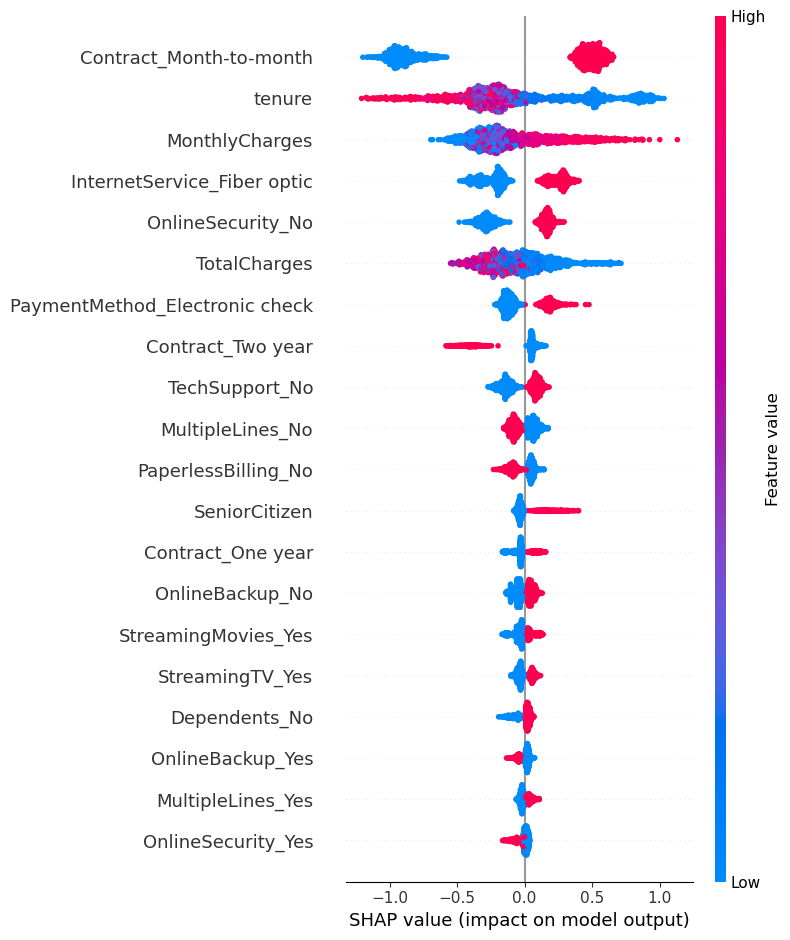

In [67]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

pipeline = final_model.estimators_[0]

xgb_model = pipeline.named_steps["classifier"]

X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X_test_df)

shap.summary_plot(shap_values, X_test_df)


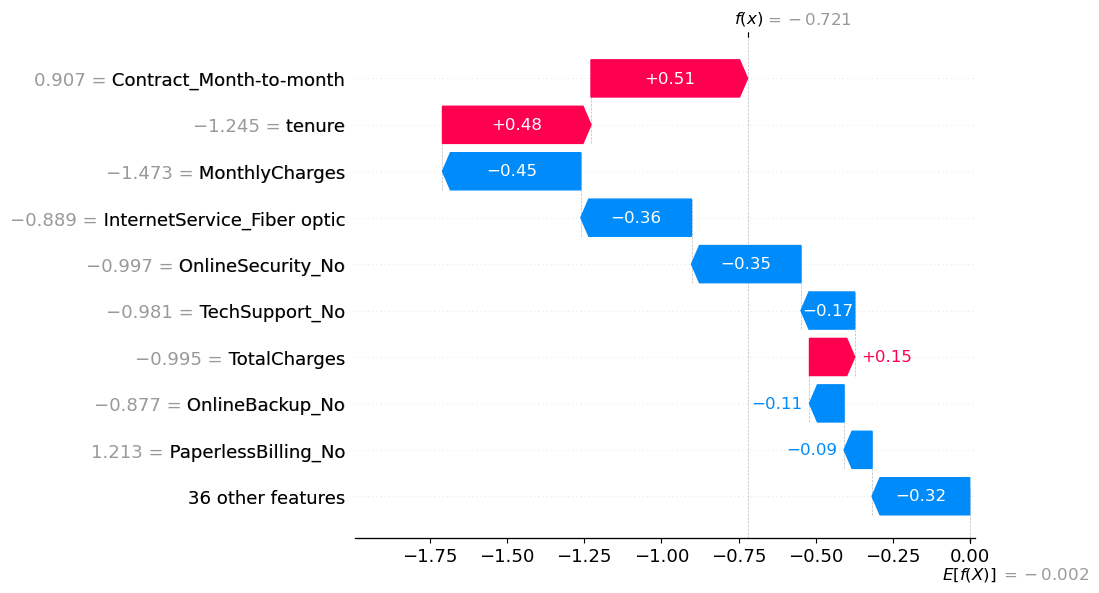

In [75]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

xgb_pipeline = final_model.estimators_[0]
xgb_model = xgb_pipeline.named_steps["classifier"]

explainer = shap.TreeExplainer(xgb_model)

churn_pos = (y_test == 1).values.argmax()
X_sample = X_test_df.iloc[[churn_pos]]

shap_values = explainer.shap_values(X_sample)
expected_value = explainer.expected_value

shap_exp = shap.Explanation(
    values=shap_values[0],
    base_values=expected_value,
    data=X_sample.values[0],
    feature_names=X_sample.columns.tolist()
)
shap.plots.waterfall(shap_exp)



In [107]:
pred_proba = model.predict_proba(X_sample)[:, 1]
pred_class = model.predict(X_sample)
print(f"Predicted probability: {pred_proba[0]:.3f}")
print(f"Predicted class: {pred_class[0]}")


Predicted probability: 0.110
Predicted class: 0


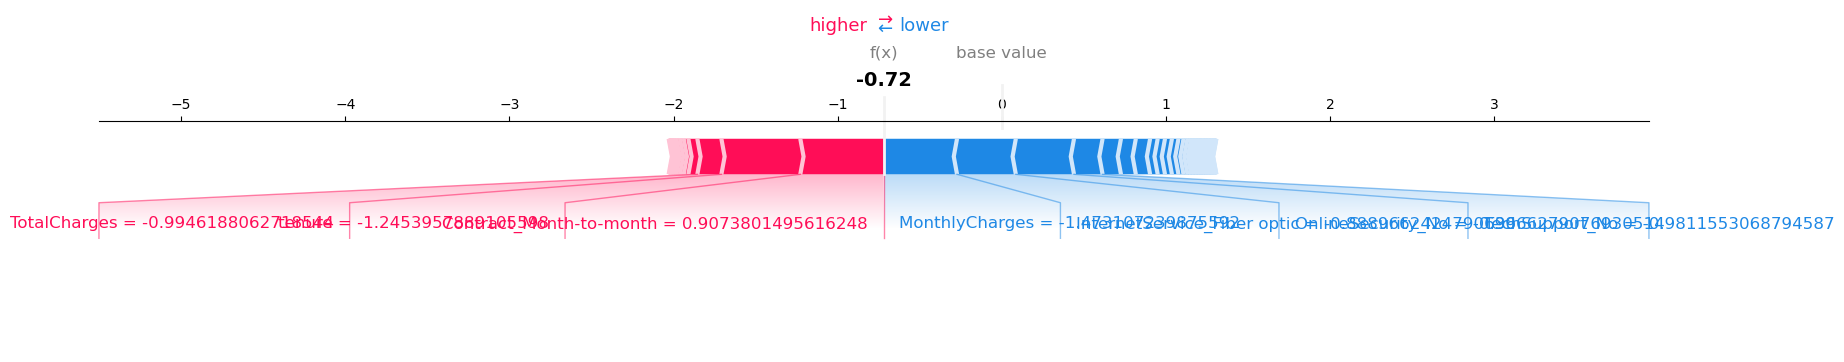

In [111]:
import shap
import matplotlib.pyplot as plt

churn_pos = (y_test == 1).values.argmax()

X_sample = X_test_df.iloc[[churn_pos]]

shap_values = explainer.shap_values(X_sample)

expected_value = explainer.expected_value

shap_exp = shap.Explanation(
    values=shap_values[0],
    base_values=expected_value,
    data=X_sample.values[0],
    feature_names=X_sample.columns.tolist()
)


shap.force_plot(
    base_value=shap_exp.base_values,
    shap_values=shap_exp.values,
    features=shap_exp.data,
    feature_names=shap_exp.feature_names,
    matplotlib=True  
)

plt.show()


In [31]:
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

ensemble_clf = EasyEnsembleClassifier(estimator=xgb_clf, n_estimators=10, random_state=42)

ensemble_clf.fit(X_train, y_train)

y_pred_ensemble = ensemble_clf.predict(X_test)
y_prob_ensemble = ensemble_clf.predict_proba(X_test)[:, 1]

print("EasyEnsembleClassifier (XGBoost base) Results:\n")
print(classification_report(y_test, y_pred_ensemble))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_ensemble))


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:31:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:31:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:31:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:31:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

EasyEnsembleClassifier (XGBoost base) Results:

              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1033
           1       0.49      0.77      0.60       374

    accuracy                           0.73      1407
   macro avg       0.69      0.74      0.70      1407
weighted avg       0.79      0.73      0.74      1407

ROC-AUC: 0.8208400846918016
